# Catan Analysis
By Jack Higgins

## To Do

- [x] Move to notebooks
- [x] Create git repo
- [x] Install git notebook extensions https://coderefinery.github.io/jupyter/version-control/
- [x] Play around with SVG library to see if it would be better https://pypi.org/project/drawSvg/
- [x] Convert point class to a collections.namedtuple https://docs.python.org/3.8/library/collections.html#collections.namedtuple
- [x] Tidy code
- [x] Refactor code so that it uses a hexagonal co-ordinate system https://www.redblobgames.com/grids/hexagons/#hex-to-pixel
- [x] Make display_board modular
- [x] Add dots to tokens
- [x] Fix issues when changing hex sizes
- [x] Use ordered elements append to create layers 
- [x] Figure out vertices
- [x] Add empty outer layer
- [x] Draw ports (4 x 3:1 + 5 x 2:1)
- [x] Add ports to board logic
- [x] Tidy up new code
- [x] Comment new functions
- [x] Add in harbors to code
- [x] Refactor graphical code
- [x] Check graphical code works
- [x] Convert np.array([q,r]) to hex(q,r)
- [x] Change name of hex_coords_mapping
- [x] Convert hexes, points and vertices to lists instead of arrays & change relevant code
- [ ] Convert vertices to tuples?
- [ ] Create function to draw vertices
- [ ] Add arguments to graphical rep functions
- [ ] Fix spelling lol
- [ ] Document code (docstrings + type annotations)
- [ ] Figure out how to make colour blind friendly
- [ ] Calculate number of possible boards

## Libraries

In [2]:
import numpy as np
from __future__ import annotations
from math import sin, cos, pi, sqrt
from dataclasses import dataclass, field
from random import randint, shuffle, seed
import drawSvg as draw

seed(2022)

## Creating the board

### Symbolic representation

Hexes, vertices and points are encoded using NumPy arrays. The following functions are used to conveniently create these objects.

In [3]:
def h(q,r):
    # Convenience wrapper for creating hexes
    return (q,r)

def v(q,r,d):
    # Convenience wrapper for creating vertices
    return (q,r,d)

def p(x,y):
    # Convenience wrapper for creating points
    return (x,y)

The following functions are used to create the underlying hexagonal grid. The grid is stored as an array of hexes.

In [4]:
def calc_number_hexes(radius: int) -> int:
    """
    Calculates the number of hexes in a hexagonal grid of given radius.
    """
    return 1 + 3 * radius * (radius + 1)


def create_hex_grid(radius):
    """
    Returns a list of hex co-ordinates in a hexagonal grid of the given radius
    """
    num_hexes = calc_number_hexes(radius)
    i = 0
    hex_grid = {}
    for q in range(-radius, radius + 1):
        r1 = max(-radius, -q - radius)
        r2 = min(radius, -q + radius)
        for r in range(r1, r2 + 1):
            hex_grid[(q, r)] = i
            i += 1
            
    return hex_grid


def axial_to_cube(hex_):
    # Convert from axial co-ordinates, (q, r), to cubic co-ordinates, (q, r, s),
    # where s = -q - r. 
    return (*hex_, -sum(hex_))

The functions below are used to assign attributes to the map.

In [5]:
def check_availible_features(num_hexes, hex_types, tokens):
    """
    Quick QC function to check if the number of hex_types, tokens 
    and ports is correct. 
    """
    if len(hex_types) != num_hexes: print("ERROR: num_hexes != len(hex_types)")
    if len(tokens) != num_hexes: print("ERROR: num_hexes != len(tokens)")
    
def assign_hex_types(availible_hex_types: ndarray[int], desert_center = False) -> ndarray[int]:
    """
    Assigns a terrain type to each hex coordinate
    """
    hex_terrains = np.random.permutation(availible_hex_types)
    
    if desert_center is True:
        desert_index = list(hex_terrains).index(0)
        # Center token is always generated as the middle index in the list
        center_index = (len(availible_tokens) - 1)//2
        hex_terrains[[desert_index, center_index]] = hex_terrains[[center_index, desert_index]]
    
    return hex_terrains

def assign_tokens(availible_tokens: ndarray[int], board_hex_types: ndarray[int]) -> ndarray[int]:
    """
    Assigns token to hexes
    Need to ensure that the 'zero' token is on the desert hex.
    """
    token_assignment = np.random.permutation(availible_tokens)
    desert_index = list(board_hex_types).index(0)
    token_zero_index = list(token_assignment).index(0)
    # Swap
    token_assignment[[desert_index, token_zero_index]] = token_assignment[[token_zero_index, desert_index]]
    return token_assignment


def assign_harbors(availible_harbors: ndarray[int]) -> ndarray[int]:
    harbor_assignment = np.random.permutation(availible_harbors)
    return harbor_assignment

Thes functions are used to create the maps.

In [6]:
def pad_array(A, size):
    d = size - len(A)
    return np.pad(A, pad_width=(0, d), mode='constant', constant_values=-1)

# np.array
def create_random_board(radius: int, 
                        availible_hex_types: ndarray[int], 
                        availible_tokens: ndarray[int],
                        availible_harbors,
                        desert_center = False) -> ndarray:
    hex_types = assign_hex_types(availible_hex_types, desert_center)
    tokens = assign_tokens(availible_tokens, hex_types)
    harbors = assign_harbors(availible_harbors)
    harbors_padded = pad_array(harbors, len(hex_types))
    board = np.array((hex_types, tokens, harbors_padded))
    return board


def create_n_random_boards(n: int,
                           radius: int, 
                           availible_hex_types: ndarray[int], 
                           availible_tokens: ndarray[int],
                           availible_harbors,
                           desert_center = False) -> ndarray:
    num_hexes = calc_number_hexes(radius)
    boards = np.zeros((n, 3, num_hexes), dtype = int)
    for i in range(n):
        board = create_random_board(radius, availible_hex_types, availible_tokens, availible_harbors, desert_center)
        boards[i] = board
        
    return(boards)

These functions are used to allow interaction with the vertices of hexes.

In [7]:
def get_vertices(h):
    """
    Given a hex h, returns the coordinates of its 6 vertices.
    https://www.redblobgames.com/grids/parts/#hexagon-coordinates
    """
    q, r = h
    vertices = [
        v(q, r, 1), 
        v(q, r + 1, 0),
        v(q + 1, r - 1, 1),
        v(q, r, 0),
        v(q, r - 1, 1),
        v(q - 1, r + 1, 0)
    ]
    return vertices

# print(get_vertices(Hex(0,0)))

def vertex_to_hex_trip(v):
    """
    Given a vertex vertex v, returns the corresponding hex trip.
    """
    q, r, d = v
    h1 = h(q,r)
    if d == 1:
        h2, h3 = h(q - 1, r + 1), h(q, r + 1)
    else:
        h2, h3 = h(q + 1, r - 1), h(q, r - 1)
    return np.array([h1, h2, h3])                                     

### Graphical representation

The following functions are used to calculate the positions of pixels.

In [8]:
def rotate(point, angle: float, origin = np.array([0,0])):
    """Rotates a two dimensional point by a given angle about another point.
    """
    i = point
    o = origin
    a = angle
    del_x = i[0] - o[0]
    del_y = i[1] - o[1]
    x = o[0] + del_x * cos(a) - del_y * sin(a)
    y = o[1] + del_x * sin(a) + del_y * cos(a)
    return p(x,y)


def hex_to_center_pixel(hex_, size: float):
    """Converts hex coords to a single xy coord denoting the hex's center.
    """
    q, r = hex_
    x = size * (sqrt(3) * q + sqrt(3)/2 * r)
    y = size * (3/2 * r)
    return p(x,y)


def hex_to_vertex_pixels(hex_, size: float):
    """Converts hex coords to six xy coords denoting the hex's vertices.
    """
    center = hex_to_center_pixel(hex_, size)
    p1 = center + np.array([0, size])
    angles = [pi/3 * x for x in range(6)]
    return np.array([rotate(p1, angle, center) for angle in angles])


def hex_intersection_to_vertex_pixel(hex_trip):
    """Converts 3 hex coords to a single xy coord denoting their shared vertex.
    """
    h1, h2, h3 = hex_trip
    c1 = hex_to_center_pixel(h1, 50)
    c2 = hex_to_center_pixel(h2, 50)
    c3 = hex_to_center_pixel(h3, 50)
    vertex = p((c1[0] + c2[0] + c3[0])/3, (c1[1] + c2[1] + c3[1])/3)
    return vertex

In [9]:
def roll_freq(value: int):
    """ Returns the relative frequency of a value being rolled by two dice.
    
    Returns the number of ways a value, between 2 and 12 inclusive, can be
    rolled by two, standard six sided die.
    
    Args:
        value: An int between 2 and 12.
    
    Return:
        rel_freq: An int, the number of different ways to roll value.
    """
    assert value >= 2 and value <= 12
    rel_freq = 6 - abs(7 - value)
    return rel_freq

In [10]:
def init_canvas(width, height):
    """ Initialise the SVG canvas on which to draw the board.
    """
    d = draw.Drawing(width, height, origin='center')
    return d


def draw_background(d):
    """ Draw the background/water hex.
    """
    origin = p(0,0)
    vertex_coords = hex_to_vertex_pixels(origin, hex_size * 5.8)
    for i in range(len(vertex_coords)):
        vertex_coords[i] = rotate(vertex_coords[i], pi/6)
    vertex_coords = vertex_coords.flatten()

    d.append(draw.Lines(*vertex_coords,close=True,
                            fill=hex_colours[6],
                            stroke=stroke_colour, stroke_width=stroke_width), z=0)
    
    
def draw_board_outline(d, hex_grid):
    """ Draw a plain outline of the board.
    """
    for hex_ in hex_grid:
        vertex_coords = hex_to_vertex_pixels(hex_, hex_size).flatten()
        d.append(draw.Lines(*vertex_coords,
                            close=True,
                            fill='#FFFFFF',
                            stroke=stroke_colour, 
                            stroke_width=stroke_width,
                            coords = hex_
                           ),
                z=1)

def draw_coords(d, hex_grid):
    """Display the coords of each hex on the board. 
    """
    for hex_ in hex_grid:
        center = hex_to_center_pixel(hex_, hex_size)
        d.append(draw.Text(str(axial_to_cube(hex_)), fontSize=18, 
                   x=center[0], y=center[1], center=True, 
                   valign = 'middle', font_family = "Open Sans", 
                   fill = 'black'), 
                 z=2)
        
    
def fill_board(d, hex_grid, board):
    """ Fill the board hexes with their type colours.
    """
    for element in d.allElements():
        try:
            hex_ = element.args['coords']
            ind = hex_grid[hex_]
            hex_type = board[0][ind]
            fill_colour = hex_colours[hex_type]
            element.args['fill'] = fill_colour
        except KeyError: 
            pass

        
def draw_tokens(d, hex_grid, board, show_dots=True):
    """ Draw each hexes token on the board.
    """
    
    radius = 25
    
    for hex_ in hex_grid:
        center = hex_to_center_pixel(hex_, hex_size)
        ind = hex_grid[hex_]
        hex_token = board[1][ind]
        if hex_token != 0:
            if hex_token == 6 or hex_token == 8:
                token_colour = token_text_colour[0]
            else:
                token_colour = token_text_colour[1]
            font_size = 31 - 2.5 * abs(7 - hex_token)

            d.append(draw.Circle(center[0], center[1], 
                                 r=radius, fill=token_fill_colour), 
                     z=2)

            if show_dots: 
                vert_off = 3 
            else: 
                vert_off = 0

            d.append(draw.Text(str(hex_token), fontSize=font_size, 
                               x=center[0], y=center[1] + vert_off, center=True, 
                               valign = 'middle', font_family = font_family, 
                               fill = token_colour, font_weight = 'bold'),
                     z=3)

            if show_dots:
                r = 1.6
                num_dots = roll_freq(hex_token)
                dots = []
                if num_dots % 2 == 0:
                    for i in range(1, num_dots // 2 + 1):
                        x_del = 3*r/2 + (i - 1) * 3 * r
                        dots.append(p(center[0] + x_del, center[1] - 15))
                        dots.append(p(center[0] - x_del, center[1] - 15))

                else:
                    for i in range(0, num_dots // 2 + 1):
                        x_del = 3 * r * i
                        dots.append(p(center[0] + x_del, center[1] - 15))
                        if x_del != 0:
                            dots.append(p(center[0] - x_del, center[1] - 15))

                for dot in dots:
                    d.append(draw.Circle(dot[0], dot[1], r, 
                                         fill = token_colour), z=3)
        



def draw_harbors(d, harbor_locations, board, simple=False):
    """Draw the harbors onto the board.
    """
    for i in range(len(harbor_locations)):
        vertex_pair = harbor_locations[i]
        hex_trip_0 = vertex_to_hex_trip(vertex_pair[0])
        hex_trip_1 = vertex_to_hex_trip(vertex_pair[1])
        p1 = hex_intersection_to_vertex_pixel(hex_trip_0)
        p2 = hex_intersection_to_vertex_pixel(hex_trip_1)
        p3 = rotate(p1, pi/3, p2)
        harbor_type = board[2][i]
        fill = harbor_colours[harbor_type]
        ratio = 3 if harbor_type == 'generic' else 2
        if not simple:
            harbor_fill = token_fill_colour
            d.append(draw.Text(f'{ratio}:1',
                               fill=fill, 
                               fontSize=12, 
                               font_family=font_family,
                               font_weight='bold', 
                               x=p3[0], y=p3[1], center=True, valign = 'middle'), 
                     z = 4)
        else:
            harbor_fill = fill
        
        d.append(draw.Circle(p3[0], p3[1], r=13, 
                     fill=harbor_fill, fill_opacity=1, 
                     stroke=fill, stroke_width=4), z=3)
        d.append(draw.Line(p1[0], p1[1], p3[0], p3[1], 
                           stroke = 'black', stroke_width=3,
                           stroke_opacity = 0.5), z=1)
        d.append(draw.Line(p2[0], p2[1], p3[0], p3[1], 
                           stroke ='black', stroke_width=3, 
                           stroke_opacity = 0.5), z=1)

        
def draw_complete_board(board, width, height, simple=False):
    """Draw the board, wrapper function.
    """
    show_dots = False if simple else True
    d = init_canvas(width, height)
    draw_background(d)
    draw_board_outline(d, board)
    fill_board(d, board)
    draw_tokens(d, board, show_dots=show_dots)
    draw_harbors(d, board, simple=simple)
    return d

### Instantiating a board

In [11]:
radius = 2

hex_type_map = np.array(['desert', 'grain', 'lumber', 'wool', 'brick', 'ore'])
harbor_type_map = np.array(['generic', 'grain', 'lumber', 'wool', 'brick', 'ore'])

availible_hex_types = (4 * [1] + 
         4 * [2] + 
         4 * [3] + 
         3 * [4] + 
         3 * [5] + 
         1 * [0])

availible_tokens = (1 * [0] +
      1 * [2] + 
      2 * [3] + 
      2 * [4] + 
      2 * [5] + 
      2 * [6] + 
      2 * [8] + 
      2 * [9] + 
      2 * [10] + 
      2 * [11] + 
      1 * [12])  

availible_harbors = (1 * [1] + 
                1 * [2] + 
                1 * [3] + 
                1 * [4] +
                1 * [5] + 
                4 * [0])

harbor_locations = [ # Specified using the vertex encoding
    [[-1,  3,  0], [-1,  2,  1]],
     [[-2,  2,  1], [-3,  3,  0]],
     [[-3,  2,  0], [-2,  0,  1]],
     [[-2,  0,  0], [-1, -2,  1]],
     [[ 0, -3,  1], [ 0, -2,  0]],
     [[ 1, -2,  0], [ 2, -3,  1]],
     [[ 2, -1,  0], [ 3, -2,  1]],
     [[ 3, -1,  1], [2, 1, 0]],
     [[1, 2, 0], [1, 1, 1]]
]

In [12]:
# Generate boards
desert_center = False
n = int(1e6)
boards_file = 'boards_1e6.npy'
# boards = create_n_random_boards(n, radius, availible_hex_types, availible_tokens, availible_harbors, desert_center)
# np.save(boards_file, boards)

In [13]:
# Load boards
boards = np.load(boards_file)

In [14]:
hex_grid = create_hex_grid(radius)
board = create_random_board(2, availible_hex_types, availible_tokens, availible_harbors, desert_center = True)
board = boards[0]
board

array([[ 5,  3,  2,  4,  3,  4,  4,  5,  2,  1,  2,  1,  1,  1,  0,  3,
         2,  3,  5],
       [ 4,  8,  9,  6,  5, 10,  4,  5,  6,  3,  9, 11, 12,  8,  0, 11,
        10,  2,  3],
       [ 4,  0,  0,  3,  0,  5,  1,  0,  2, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1]])

In [15]:
width = 600
height = width
hex_size = 50
hex_colours = {
    0: '#DCBB96',
    1: '#DFB853',
    2: '#20703D',
    3: '#A7C957',
    4: '#C37C3A',
    5: '#969696',
    6: '#B9E3F3'
}
token_fill_colour = "#FFEDD0"
token_text_colour = ("#BD0000", "#100C08")
harbor_colours = { # Darker shades of hex_colours
    0: '#2A1B0D',
    1: '#D9A82E',
    2: '#1B5F34',
    3: '#93B93C',
    4: '#A86B32',
    5: '#969696'
}

font_family = "Open Sans"
stroke_colour = "#100C08"
stroke_width = 3

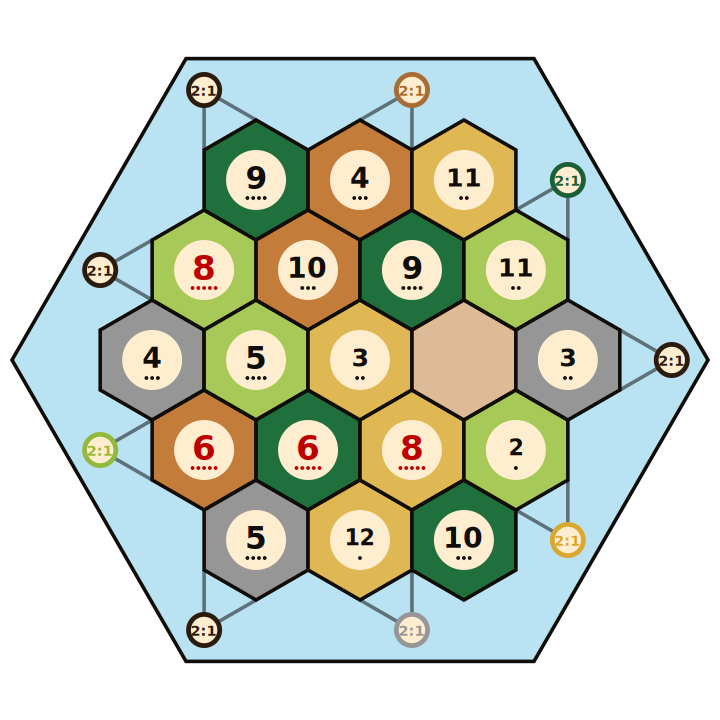

In [16]:
d = init_canvas(width, height)
draw_background(d)
draw_board_outline(d, hex_grid)
fill_board(d, hex_grid, board)
draw_tokens(d, hex_grid, board, show_dots=True)
draw_harbors(d, harbor_locations, board, simple=False)
d.setPixelScale(1.2)
d

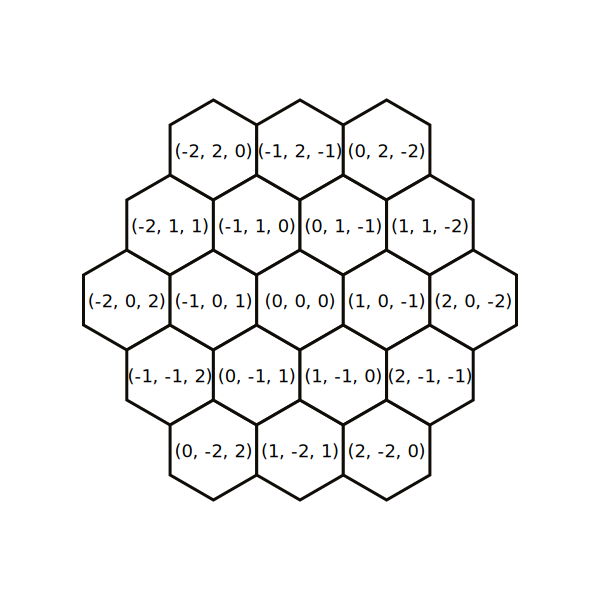

In [17]:
d = init_canvas(width, height)
draw_board_outline(d, hex_grid)
draw_coords(d, hex_grid)
d

## Metrics (new)

1. Resource distribution (global)
2. Resource clustering (local)
3. Probability distribution (global)
4. Number clustering (local)
5. Probability distribution per resource type (global?)
6. Harbor placement (by resource type)? (local?)

In [18]:
def create_vertex_grid(hex_grid):
    vertex_list = []
    for hex_ in hex_grid:
        vertices = get_vertices(hex_)
        vertex_list += vertices
    return np.unique(vertex_list, axis = 0)

vertex_grid = create_vertex_grid(hex_grid)

In [19]:
def normalise(x):
    x = np.asarray(x)
    return (x - x.min()) / (np.ptp(x))

### 1. Resource distribution

Note that the board is symmetrical about the axes of the grid (q, r and s). Drawing a line along each axis divides the board in two. For each axis halving, consider the sum of the number of resoures produced per terrain type across all possible hex locations. Take the difference between the two halves and sum. Sum across all three axes. 

In [20]:
def calc_RSI_tile(board, hex_grid):
    # Calculates the resource symmetry index, on a hex basis
    squared_diffs = 0
    hex_types = board[0]
    for axis in range(3): # 0, 1 and 2 correspond to q, r and s respectively. 
        count = [0] * 6
        for hex_coord, hex_index in hex_grid.items():
            hex_type = hex_types[hex_index]
            hex_coord = axial_to_cube(hex_coord)
            if hex_coord[axis] < 0:
                count[hex_type] -= 1
            elif hex_coord[axis] > 0:
                count[hex_type] += 1
        # Don't include the desert hex
        squared_diffs += sum([i**2 for i in count[1:]])
    return squared_diffs

In [21]:
calc_RSI_tile(board, hex_grid)

18

In [22]:
def axial_to_cube_vertex(vertex):
    return [vertex[0], vertex[1], -(sum(vertex[:2])), vertex[2]]

In [23]:
# Resourced symmetry index
def calc_RSI(board, vertex_grid, hex_grid):
    counts = np.zeros((3,6), dtype = int)
    hex_types = board[0]
    
    for vertex in vertex_grid:
        hexes = vertex_to_hex_trip(vertex)
        # Cube coordinates make it easier to loop over the axes
        vertex = axial_to_cube_vertex(vertex) 

        for axis in range(3):
            # Given the axis, determines whether or not the vertex is on the
            # negative or positive side of the axis. 
            # TODO: Make this if-else chain simpler, or create function
            if vertex[axis] != 0:
                change = np.sign(vertex[axis])
            else:
                if (vertex[3] == 1 and axis == 1) or (vertex[3] == 0 and axis == 0) or (vertex[3] == 0 and axis == 2):
                    change = 1
                else:
                    change = -1
            for hex_ in hexes:
                if tuple(hex_) in hex_grid:
                    hex_index = hex_grid[tuple(hex_)] # TODO: Remove need for tuple
                    hex_type = hex_types[hex_index] # TODO: Make getting hex type a function
                    counts[axis][hex_type] += change
    
    return np.sum(counts**2)
                
            
calc_RSI(board, vertex_grid, hex_grid)

720

In [42]:
RSI_scores = []
for board in boards[:10000]:
    RSI_scores.append(calc_RSI(board, vertex_grid, hex_grid))

    
RSI_scores_n = normalise(RSI_scores)

In [43]:
np.sort(RSI_scores)[:10]

array([ 72, 216, 216, 288, 288, 288, 288, 288, 288, 288])

In [44]:
np.argsort(RSI_scores)[:10]

array([3796, 5562,  972,  901, 5089, 3371, 8744, 6577, 5649, 4234])

In [45]:
top_board = np.argsort(RSI_scores)[0]

In [46]:
boards[top_board]

array([[ 1,  4,  2,  3,  3,  5,  2,  1,  5,  0,  1,  4,  2,  2,  3,  3,
         4,  5,  1],
       [ 4, 11,  5,  9, 10,  3,  2,  9,  4,  0,  8, 10,  6,  8,  5, 11,
        12,  6,  3],
       [ 4,  1,  3,  0,  0,  0,  5,  0,  2, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1]])

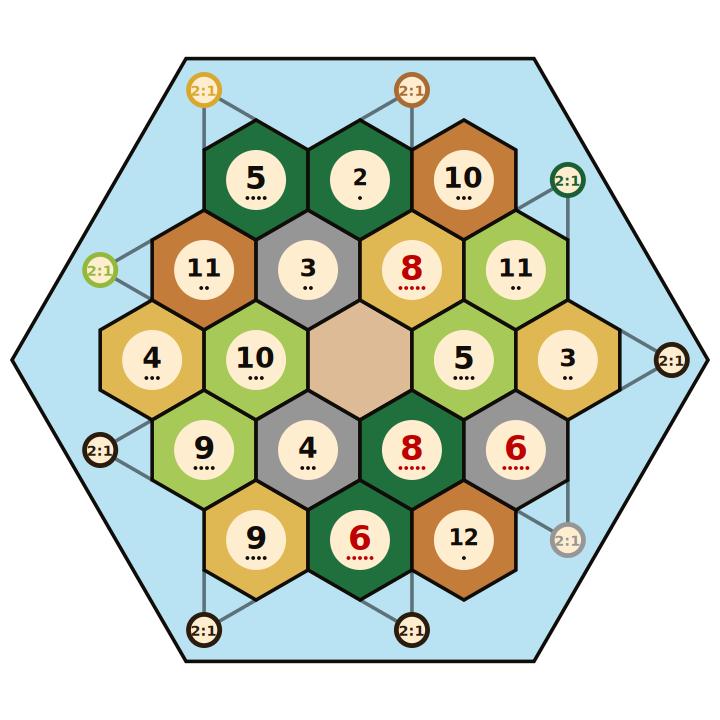

In [47]:
d = init_canvas(width, height)
draw_background(d)
draw_board_outline(d, hex_grid)
fill_board(d, hex_grid, boards[top_board])
draw_tokens(d, hex_grid, boards[top_board], show_dots=True)
draw_harbors(d, harbor_locations, boards[top_board], simple=False)
d.setPixelScale(1.2)
d

# Metrics

## Tokens
- [x] Token distribution across hex types
- [ ] Token distribution across board locations 

## Types
- [ ] Terrain distribution across the board
    - [x] Global distribution: symmetry
    - [ ] Local distribution: terrain clusters


## Ports
- Port proximity to respective resource
- Port "diversity" (mixing of 2:1 and 3:1)

In [ ]:
def normalise(x):
    x = np.asarray(x)
    return (x - x.min()) / (np.ptp(x))

# Tokens

## Token distribution across hex types
- How are the token numbers spread between the different hex types?
- We could consider the distributions to be more 'fair' if each hex type has a roughly equal chance of producing resources each turn.

In [ ]:
def calc_token_hex_score(board):
    dist = {'wool': 0, 'grain': 0, 'lumber': 0, 'ore': 0, 'brick': 0}    

    for hex_ in board.hexes:
        hex_type = board.hex_types[hex_]
        if hex_type != 'desert':
            dist[hex_type] += roll_freq(board.hex_tokens[hex_])

    for key in dist.keys():
        if key in ['wood', 'grain', 'lumber']:
            dist[key] = dist[key] / 4
        else:
            dist[key] = dist[key] / 3

    v = var(dist.values()) * 5 # TODO: Make this more elegant

    return v
    

## Token distribution across location
- How are the token numbers spread across the board by location?
- Break down into two categories:
    - Probability: We could consider the distribution to be 'fair' if each vertex roughly equal chance (accounting for the number of adjacent tiles) of producing resources per turn.
    - Diversity: We could consider the distribution to be 'balanced' if adjacent hexes don't share the same token number. 

### Probability

In [ ]:
d = init_canvas(700, 700)
b = init_board(radius = 3)
draw_board_outline(d, b)
draw_coords(d, b)
d

In [ ]:
def calc_vertex_prob_score(board):
    # TODO: Make this into a separate function
    vertex_set = set()
    for hex_ in board.hexes:
        vertices = get_vertices(hex_)
        vertex_set.update(vertices)
    
    prob_list = []
    for v in vertex_set:
        hexes = vertex_to_hex_trip(v)
        prob = 0
        num_tiles_on_board = 0
        # print(f"hex triple = {hexes}")
        for hex_ in hexes:
            if hex_ in board.hexes:
                num_tiles_on_board += 1
                hex_token = board.hex_tokens[hex_]
                if hex_token is not None:
                    prob += roll_freq(hex_token)
                    # print(f"hex = {hex_}")
                    # print(f"token = {hex_token}, dots = {roll_freq(hex_token)}")

        weighted_prob = prob * num_tiles_on_board/3
        # print(f"Total prob = {prob}, w_prob = {weighted_prob}")
        prob_list.append(weighted_prob)
    
    prob_var = var(prob_list)
    return(prob_var)

    # prob_delta = max(prob_list) - min(prob_list)
    # return prob_delta

In [ ]:
1e8/20369419560 * 100

In [ ]:
n_iter = int(1e5)
boards = []

for i in range(n_iter):
    boards.append(create_random_board(2, hex_types, tokens, 
                            harbor_locations, harbor_types))

In [ ]:
# import sys
# sys.getsizeof(boards) / 1e6

In [ ]:
v_prob_scores = []

for i in range(n_iter):
    board = boards[i]
    v_prob_scores.append(calc_vertex_prob_score(board))

In [ ]:
v_prob_scores_n = normalise(v_prob_scores)

np.sort(v_prob_scores_n)[:10]
np.argsort(v_prob_scores_n)[:10]
top_board = np.argsort(v_prob_scores_n)[0]

In [ ]:
d = draw_complete_board(boards[np.argsort(v_prob_scores_n)[2]], width, height)
d

Problem: This results in 'weird' distributions of tokens. Maybe better off trying to make each hex neighbour hexes with different number of dots?

In [ ]:
from collections import Counter

a = [Hex(0,0), Hex(1,0), Hex(0,1)]
b = [Hex(1,0), Hex(0,0), Hex(0,1), Hex(2,2)]

Counter(a) == Counter(b)

### Diversity

# Terrains

## Global distribution
- How are the terrains spread over the board overall?
- Multiple candidate approaches, including:
    - Maximising the sum of average distances between tiles with the same terrain.
    - Minimising the difference in the number of terrain types on opposite sides of axes.


In [ ]:
def get_terrain_locations(board: board, terrain: str):
    locations = []
    for hex_ in board.hexes:
        hex_type = board.hex_types[hex_]
        if hex_type == terrain:
            locations.append(hex_)
    return locations
            

def hex_distance(h1, h2):
    distance = max(abs(h1.q - h2.q), abs(h1.r - h2.r), abs(h1.s - h2.s))
    return distance

The minimising variance of the average distance doesn't produce nice results. 

In [ ]:
locations = get_terrain_locations(board, 'lumber')
print(locations)
distances = [] 

# TODO: Make this more efficient, double counts each edge
for h1 in locations:
    for h2 in locations:
        if h1 != h2:
            distance = hex_distance(h1, h2)
            distances.append(distance)
            
print(mean(distances))


In [ ]:
min_var = 100
min_dist = None 
min_board = None


hex_types_unique = list(set(hex_types))
hex_types_unique.remove('desert')

for i in range(10000):
    board = create_random_board(2, hex_types, tokens, 
                                harbor_locations, harbor_types)
    avg_distances = []

    for hex_type in hex_types_unique:
        locations = get_terrain_locations(board, hex_type)
        distances = [] 

        # TODO: Make this more efficient, double counts each edge
        for h1 in locations:
            for h2 in locations:
                if h1 != h2:
                    distance = hex_distance(h1, h2)
                    distances.append(distance)
        avg_distances.append(mean(distances))
            

    v = var(avg_distances)
    if v < min_var:
        min_var = v
        min_dist = avg_distances
        min_board = board


In [ ]:
print(min_var)
print(min_dist)
d = draw_complete_board(min_board, width, height)
d.setPixelScale(1.2)
d

### Maximising sum of average distances

In [ ]:
max_sum = 0
max_dist = None 
min_board = None


hex_types_unique = list(set(hex_types))
hex_types_unique.remove('desert')

for i in range(100000):
    board = create_random_board(2, hex_types, tokens, 
                                harbor_locations, harbor_types)
    avg_distances = []

    for hex_type in hex_types_unique:
        locations = get_terrain_locations(board, hex_type)
        distances = [] 

        # TODO: Make this more efficient, double counts each edge
        for h1 in locations:
            for h2 in locations:
                if h1 != h2:
                    distance = hex_distance(h1, h2)
                    distances.append(distance)
        avg_distances.append(mean(distances))
            

    s = sum(avg_distances)
    if s > max_sum:
        max_sum = s
        max_dist = avg_distances
        min_board = board


In [ ]:
print(max_sum)
print(min_dist)
d = draw_complete_board(min_board, width, height)
d.setPixelScale(1.2)
d

### Minimising the difference in the number of terrain types on opposite sides of axes

In [ ]:
min_sum = 100
min_board = None

for i in range(100000):
    board = create_random_board(2, hex_types, tokens, 
                                harbor_locations, harbor_types)

    squared_diffs = 0
    for axis in ['q', 'r', 's']:
        count = {'wool': 0, 'grain': 0, 'lumber': 0, 'ore': 0, 'brick': 0}
        for hex_ in board.hexes:
            hex_type = board.hex_types[hex_]
            if hex_type != 'desert':
                if getattr(hex_, axis) < 0:
                    count[hex_type] -= 1
                elif getattr(hex_, axis) > 0:
                    count[hex_type] += 1
        squared_diffs += sum([i**2 for i in count.values()])
    
    if squared_diffs < min_sum:
        min_sum = squared_diffs
        min_board = board
        

In [ ]:
print(min_sum)
d = draw_complete_board(min_board, width, height)
d.setPixelScale(1.2)
d

## Local distribution
- The methods used above don't directly discourage an even distribution on a 'local' level; often optimising these measures along results in tiles of the same type clustering together.
- Ideally, no two resources of the same type should be adjacent.
- We create another metric to measure the number of neighbours a tile has of the same type, and attempt to minimise it.


Need an approach to directly penalise having neighbours of the same type.

In [ ]:
def get_neighbours(hex_, board):
    directions = [Hex(1, 0), Hex(1, -1), Hex(0, -1), 
                  Hex(-1, 0), Hex(-1, 1), Hex(0, 1)]
    neighbours = []
    for vec in directions:
        neighbour = hex_ + vec
        if hex_distance(Hex(0,0), neighbour) <= board.radius:
            neighbours.append(neighbour)
            
    return neighbours


score = 0
for hex_ in board.hexes:
    neighbours = get_neighbours(hex_, board)
    hex_type = board.hex_types[hex_]
    for neighbour in neighbours:
        if board.hex_types[neighbour] == hex_type:
            score += 1

In [ ]:
def calc_clustering_score(board):
    score = 0
    for hex_ in board.hexes:
        neighbours = get_neighbours(hex_, board)
        hex_type = board.hex_types[hex_]
        for neighbour in neighbours:
            if board.hex_types[neighbour] == hex_type:
                score += 1
    return(score)

def calc_symmetry_score(board):
    squared_diffs = 0
    for axis in ['q', 'r', 's']:
        count = {'wool': 0, 'grain': 0, 'lumber': 0, 'ore': 0, 'brick': 0}
        for hex_ in board.hexes:
            hex_type = board.hex_types[hex_]
            if hex_type != 'desert':
                if getattr(hex_, axis) < 0:
                    count[hex_type] -= 1
                elif getattr(hex_, axis) > 0:
                    count[hex_type] += 1
        squared_diffs += sum([i**2 for i in count.values()])

    return squared_diffs


In [ ]:
results = []
boards = []

n_iter = int(1e5)

for i in range(n_iter):
    board = create_random_board(2, hex_types, tokens, 
                            harbor_locations, harbor_types)
    cluster_score = calc_clustering_score(board)
    results.append(cluster_score)
    boards.append(board)
    

In [ ]:
results_sorted = np.sort(results)
indices_sorted = np.argsort(results)

In [ ]:
for i in range(len(results_sorted)):
    if results_sorted[i] == 0:
        pass
    else:
        print(i)
        break
    

In [ ]:
d = draw_complete_board(boards[28377], width, height)
d.setPixelScale(1.2)
d

## Packaging it together

In [ ]:
cluster = []
symm = []
token_hex = []
v_freq = []
boards = []

n_iter = int(1e5)

for i in range(n_iter):
    board = create_random_board(2, hex_types, tokens, 
                            harbor_locations, harbor_types)
    cluster.append(calc_clustering_score(board))
    symm.append(calc_symmetry_score(board))
    token_hex.append(calc_token_hex_score(board))
    v_freq.append(calc_vertex_prob_score(board))
    boards.append(board)

In [ ]:
np.sort(normalise(token_hex))

In [ ]:
np.percentile(normalise(token_hex), [0.1, 25, 50, 75, 99.9])

In [ ]:


token_hex_n = normalise(token_hex)
cluster_n = normalise(cluster)
symm_n = normalise(symm)
v_freq_n = normalise(v_freq)


w = 1
v = 1
u = 1
results_sum = cluster_n * w + symm_n +  v * token_hex_n + u * v_freq_n

In [ ]:
n = 20
print(f"Top {n} result scores: \n {np.sort(results_sum)[:n]}")
print(f"Top {n} board indexes: \n {np.argsort(results_sum)[:n]}")

top_board_index = np.argsort(results_sum)[0]

In [ ]:
d = draw_complete_board(boards[top_board_index], width, height)
d.setPixelScale(1.2)
d

In [ ]:
desert_origin = 0
for board in boards:
    if board.hex_types[Hex(0,0)] == "desert":
        desert_origin += 1
        
print(desert_origin/n_iter)

In [ ]:
desert_origin = 0
for i in range(100):
    board = boards[np.argsort(results_sum)[i]]
    if board.hex_types[Hex(0,0)] == "desert":
        desert_origin += 1
        
print(desert_origin/100)